## Ravita Kartawinata
[Ravita's Git's Token-norm](https://github.com/Pii-USD/509-tm-token-norm)

# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import string
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import itertools

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/rkartawi/Desktop/Ravita/MSADS/509/ads509-tm-scrape/"

# These subfolders should still work if you correctly stored the data from the Mod 1 
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :      
    # Given a list of tokens, print number of tokens, number of unique tokens, and number of characters
    # Fill in the correct values here. 
    num_tokens_tot = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(
        len(token) for token in tokens)    
    
    # Get lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
    # and num_tokens,  most common tokens.
    lexical_diversity = num_unique_tokens / num_tokens_tot \
        if num_tokens_tot > 0 else 0.0
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(num_tokens)

    if verbose :        
        print(f"There are {num_tokens_tot} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")  
        print(f"The {num_tokens} most common tokens are:")
        for token, count in most_common_tokens:
            print(f"{token}: {count}")
        
    # Return a list with the number of tokens, number of unique tokens,
    # lexical diversity, and number of characters, most common tokens
    return [num_tokens_tot, num_unique_tokens, lexical_diversity, \
            num_characters, most_common_tokens]

In [5]:
text = """here is some example text with other example 
    text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The 5 most common tokens are:
text: 3
here: 2
example: 2
is: 1
some: 1


Q: Why is it beneficial to use assertion statements in your code? 

A: An assertion statement is a tool to test if a condition of the code is true. If the condition is True, the program continues running; 
if it evaluates to False, an AssertionError is raised, and the optional error message is displayed. 

Some of benefits of assertion statements are: 
- It helps catching bugs early by verifying conditions at specific points because it improves code reliability by ensuring assumptions hold.
- It makes code easier to understand by explicitly showing expected behaviors.
- It prevents invalid inputs or states from propagating through the program.
- During development, assertions complement testing with lightweight checks and it can be disabled in production to avoid performance issues.
  
Overall, they enhance code robustness and make debugging easier.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data 
def read_lyrics_data(lyrics_folder):
    lyrics_data = {}
    # Loop through each artist's subfolder
    for artist in os.listdir(lyrics_folder):
        artist_folder = os.path.join(lyrics_folder, artist)
        lyrics_data[artist] = []
        
        # Loop through songs in artist's folder
        for song_file in os.listdir(artist_folder):
            song_path = os.path.join(artist_folder, song_file)
            with open(song_path, 'r', encoding='utf-8') as f:
                lyrics_content = f.read().strip()
                lyrics_data[artist].append(lyrics_content)
                # print(f"{artist}: {lyrics_content}")
    return lyrics_data
lyrics_data = read_lyrics_data(lyrics_folder)

In [7]:
# Read in the twitter data
target_filenames = ['robynkonichiwa_followers_data.txt', 'cher_followers_data.txt']
def read_twitter_data(twitter_folder):
    twitter_data = {}
    for filename in os.listdir(twitter_folder):
        if filename in target_filenames:
            file_path = os.path.join(twitter_folder, filename)
            with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                twitter_data[filename] = f.read().strip()
    return twitter_data
twitter_data = read_twitter_data(twitter_folder)

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [9]:
punctuation = set(punctuation) # speeds up comparison
def clean_text(text):
    # Remove punctuation include hashtag
    # text = ''.join(char for char in text if char not in string.punctuation)
    text = text = ''.join(
        char for char in text 
        if char not in string.punctuation.replace('#', '')) # Thanks to ChatGPT  
    # Convert to lowercase
    text = text.lower()
    # Remove "lyrics'
    text = re.sub(r'\blyrics\b', '', text, flags=re.IGNORECASE)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return cleaned_tokens

In [10]:
#create your clean twitter data here 
# remove #
def clean_twitter_data(twitter_data):
    cleaned_twitter_data = {}
    for filename, description in twitter_data.items():
        cleaned_tokens = re.sub(r'#(\w+)', r'\1', description)
        cleaned_tokens = clean_text(cleaned_tokens)
        cleaned_twitter_data[filename] = cleaned_tokens
    return cleaned_twitter_data
cleaned_twitter_data = clean_twitter_data(twitter_data)

In [11]:
# for filename, tokens in cleaned_twitter_data.items():
#     print(f"Filename: {filename}")
#     print(f"Cleaned Description (first 1000 characters):\n{tokens[:1000]}")
#     print("\n" + "="*50 + "\n")

In [12]:
# create your clean lyrics data here
def clean_lyrics_data(lyrics_data):
    cleaned_lyrics = {}
    for artist, songs in lyrics_data.items():
        cleaned_lyrics[artist] = []
        for song_lyrics in songs:
            # cleaned_song = re.sub(r'\s+', ' ', song_lyrics) # addition to the last question
            # cleaned_song = clean_text(cleaned_song)          
            cleaned_song = clean_text(song_lyrics)          
            cleaned_song = [word for word in cleaned_song if word != 'azlyricscom']
            cleaned_lyrics[artist].append(cleaned_song)
            # print(cleaned_lyrics)
    return cleaned_lyrics
cleaned_lyrics_data = clean_lyrics_data(lyrics_data)

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [13]:
artist_tokens = {}
# Lyric Stats
for artist, songs in cleaned_lyrics_data.items():
    # Flatten all song tokens for the current artist
    # Since Lyrics is in Nested Dict.
    all_tokens = list(itertools.chain.from_iterable(songs))
    artist_tokens[artist] = all_tokens

for artist, tokens in artist_tokens.items():
    print(f"Artist lyric contents: {artist}")
    stats = descriptive_stats(tokens, num_tokens=5, verbose=True)
    print("-" * 50)

Artist lyric contents: cher
There are 5493 tokens in the data.
There are 1392 unique tokens in the data.
There are 26412 characters in the data.
The lexical diversity is 0.253 in the data.
The 5 most common tokens are:
come: 101
dont: 94
baby: 87
see: 80
girl: 61
--------------------------------------------------
Artist lyric contents: robyn
There are 3153 tokens in the data.
There are 649 unique tokens in the data.
There are 15447 characters in the data.
The lexical diversity is 0.206 in the data.
The 5 most common tokens are:
love: 103
robyn: 97
show: 78
know: 74
dont: 62
--------------------------------------------------


In [14]:
# twitter Stats
for filename, tokens in cleaned_twitter_data.items():
    print(f"Filename: {filename}")
    stats = descriptive_stats(tokens, num_tokens=5, verbose=True)
    print("-" * 50)

Filename: cher_followers_data.txt
There are 30117921 tokens in the data.
There are 5739231 unique tokens in the data.
There are 193751046 characters in the data.
The lexical diversity is 0.191 in the data.
The 5 most common tokens are:
love: 222404
im: 142232
usa: 140927
life: 126924
new: 106580
--------------------------------------------------
Filename: robynkonichiwa_followers_data.txt
There are 2789269 tokens in the data.
There are 720577 unique tokens in the data.
There are 18362481 characters in the data.
The lexical diversity is 0.258 in the data.
The 5 most common tokens are:
music: 16094
sweden: 12744
love: 12237
new: 10255
stockholm: 9707
--------------------------------------------------


Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: If we left stopwords which include conjunctions, prepositions, articles, pronouns, and auxiliary verbs, the result will generate less meaningful words, because there would be possibilities that these stopwords would be most dominant. It could skew the results since it emphasizes frequent words that don't add much insight into the text’s content. On the otherhands, removing stopwords allows the analysis to get more significant and content-rich words. This often leads to a list of top words that better reflect the core themes and topics of the text. By excluding stopwords, it would enhance the relevance and accuracy of text analysis. The final result will highlight words that contribute more meaningfully to understanding the text. 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: Lexical diversity refers to the variety of unique words used in a text or speech. It reflects the richness of the vocabulary in the lyrics. I was under impression that most of artists use similar range of vocabulary in their lyrics as long as their songs express similar themes regardless the genre. After analyzing the artists' lyrics, I found that their lexical diversity was similar; which would support the belief that artists generally have a comparable vocabulary range. However, an interesting finding would suggest that factors such as genre or lyrical approach would play a more substantial role. These differences would challenge my prior assumption and highlight how artistic style impacts language or words use. For example, an artist who sings a love theme for hiphop or rap genre, the lyrics might contain more explicit languages compare to country or pop genre. If we include specific stopword based genre themes, the results confirm that lexical diversity is consistent across artists based on the themes. Thus, the analysis provides valuable insights into the relationship between lyrical content and lexical diversity.




## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [15]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [16]:
# Your code here
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Thanks to ChatGPT  
def group_emojis_by_artist(cleaned_twitter_data):
    grouped_emojis = {}
    for filename, tokens in cleaned_twitter_data.items():
        artist = filename.split('_')[0]
        text = ' '.join(tokens)
        emojis = extract_emojis(text)
        if artist not in grouped_emojis:
            grouped_emojis[artist] = []
        grouped_emojis[artist].extend(emojis)
    return grouped_emojis

grouped_emojis = group_emojis_by_artist(cleaned_twitter_data)
most_common_emojis = {}

for artist, emojis in grouped_emojis.items():
    emojis_counter = Counter(emojis)
    stats = descriptive_stats(emojis_counter, num_tokens=10, verbose=False)
    most_common_emojis[artist] = stats[4]

for artist, common_tokens in most_common_emojis.items():
    print(f"Artist: {artist}")
    print("Most common emojis in twitter:")
    for token, count in common_tokens:
        print(f"{token}: {count}")
    print()

Artist: cher
Most common emojis in twitter:
❤: 94506
🌈: 66291
♥: 48059
🏳: 47174
✨: 45846
🌊: 31234
💙: 31050
🏻: 25195
✌: 21963
💜: 21571

Artist: robynkonichiwa
Most common emojis in twitter:
🌈: 6086
❤: 5635
🏳: 4641
♥: 4249
✨: 3217
🏻: 1751
✌: 1495
♀: 1347
🏼: 1340
💙: 1200



### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [17]:
def clean_twitter_data(twitter_data):
    cleaned_twitter_data = {}
    for filename, description in twitter_data.items():
        cleaned_tokens = clean_text(description) #keeping #hashtag
        cleaned_twitter_data[filename] = cleaned_tokens
    return cleaned_twitter_data
cleaned_twitter_data = clean_twitter_data(twitter_data)

In [18]:
def extract_hashtags(text): 
    return re.findall(r'#\w+', text)

def combine_hashtags_back(twitter_data, cleaned_twitter_data): 
    combined_data = {}
    for filename, description in twitter_data.items():
        cleaned_tokens = cleaned_twitter_data[filename]
        hashtags = extract_hashtags(description)
        combined_tokens = cleaned_tokens + hashtags
        combined_data[filename] = combined_tokens
    return combined_data
recombined_cleaned_twitter_data = \
    combine_hashtags_back(twitter_data, cleaned_twitter_data)

In [19]:
def group_hashtags_by_artist(recombined_cleaned_twitter_data):
    grouped_hashtags = {}
    for filename, tokens in recombined_cleaned_twitter_data.items():
        artist = filename.split('_')[0]
        text = ' '.join(tokens)
        hashtags = extract_hashtags(text)
        if artist not in grouped_hashtags:
            grouped_hashtags[artist] = []
        grouped_hashtags[artist].extend(hashtags)
    return grouped_hashtags
grouped_hashtags = group_hashtags_by_artist(recombined_cleaned_twitter_data)

most_common_hashtags = {}
for artist, hashtags in grouped_hashtags.items():
    hashtag_counter = Counter(hashtags)
    stats = descriptive_stats(hashtag_counter, num_tokens=10, verbose=False)
    most_common_hashtags[artist] = stats[4]

for artist, common_tokens in most_common_hashtags.items():
    print(f"Artist: {artist}")
    print("Most common hashtag in twitter:")
    for token, count in common_tokens:
        print(f"{token}: {count}")
    print()

Artist: cher
Most common hashtag in twitter:
#BLM: 10100
#Resist: 6161
#BlackLivesMatter: 4888
#resist: 3860
#FBR: 3330
#1: 3111
#TheResistance: 3044
#blacklivesmatter: 2738
#Resistance: 1953
#RESIST: 1878

Artist: robynkonichiwa
Most common hashtag in twitter:
#BlackLivesMatter: 356
#BLM: 345
#1: 228
#blacklivesmatter: 222
#music: 175
#Music: 114
#EDM: 87
#LGBTQ: 76
#blm: 60
#TeamFollowBack: 59



### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [20]:
def extract_song_title(text):
    match = re.search(r'- (.+?) \|', text)
    if match:
        return match.group(1).strip()
    return text.strip()
    
def process_lyrics_data(lyrics_data):
    song_titles = {}
    for artist, lyrics_list in lyrics_data.items():
        song_titles[artist] = []
        for lyrics in lyrics_list:
            lines = lyrics.split('\n')
            if lines:
                song_title = lines[0].strip()
                song_title = song_title.replace(' Lyrics', '')
                extracted_title = extract_song_title(song_title)
                cleaned_title = clean_text(extracted_title)
                song_titles[artist].extend(cleaned_title)
    return song_titles

In [21]:
# Your code here
song_titles = process_lyrics_data(lyrics_data)
most_common_tokens_by_artist_title = {}

for artist, tokens in song_titles.items():
    counter = Counter(tokens)
    stats = descriptive_stats(counter, num_tokens=5, verbose=False)
    most_common_tokens_by_artist_title[artist] = stats[4]

for artist, common_tokens in most_common_tokens_by_artist_title.items():
    print(f"Artist: {artist}")
    print("Most common tokens in song titles:")
    for token, count in common_tokens:
        print(f"{token}: {count}")
    print()

Artist: cher
Most common tokens in song titles:
come: 4
girl: 2
bang: 2
baby: 2
sleep: 2

Artist: robyn
Most common tokens in song titles:
want: 2
show: 2
go: 2
heart: 2
love: 2



### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

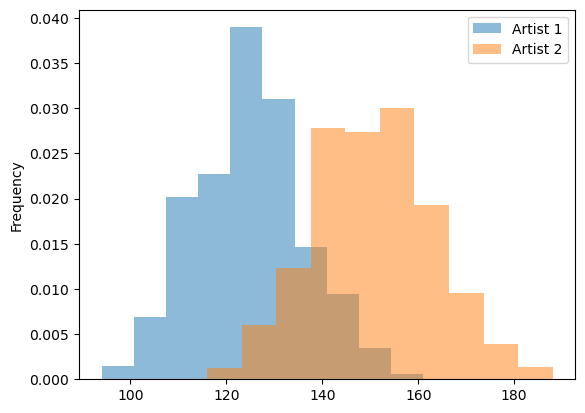

In [22]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The regular expression '\s+' matches one or more consecutive whitespace characters such as spaces, tabs, newlines. 
This expression is usually used for normalizing text on removing whitespace(s).


In [23]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

artist
cher     Axes(0.125,0.11;0.775x0.77)
robyn    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

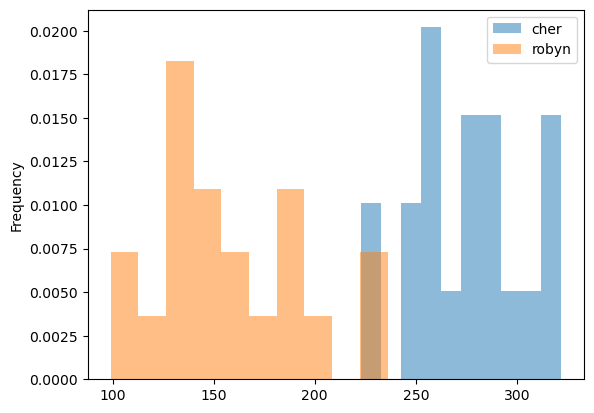

In [24]:
# all songs length by artist
data = []
for artist, songs in cleaned_lyrics_data.items():
    for i, song_tokens in enumerate(songs):
        song_length = len(tokenize_lyrics(' '.join(song_tokens)))
        data.append({'artist': artist, 'song': f'song{i+1}', 'length': song_length})        
           
df = pd.DataFrame(data)
df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

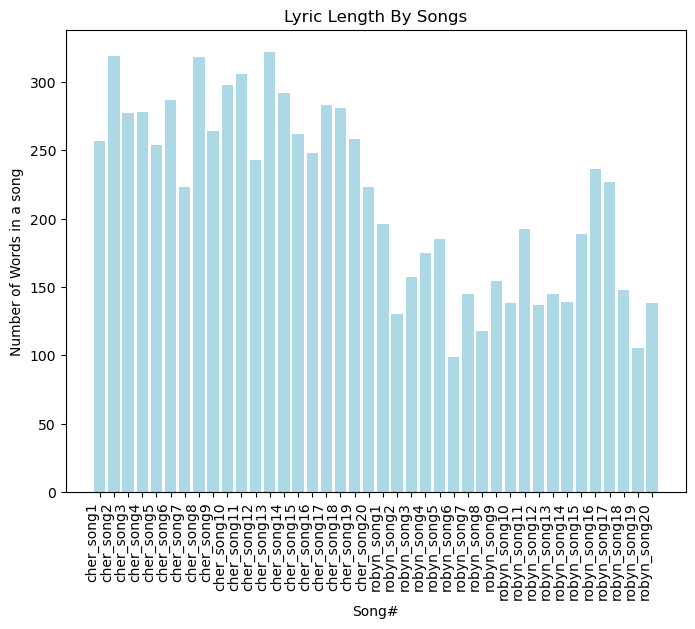

In [25]:
# Your lyric length comparison chart here. 
# By lyric 
lyric_lengths = {}
for artist, songs in cleaned_lyrics_data.items():
    lyric_lengths[artist] = [len(tokenize_lyrics(' '.join(song))) for song in songs]

songs = []
lengths = []
for artist, lengths_list in lyric_lengths.items():
    for i, length in enumerate(lengths_list): # Flatten the Nested Dic
        songs.append(f"{artist}_song{i+1}")
        lengths.append(length)

plt.figure(figsize=(8, 6))
plt.bar(songs, lengths, color='lightblue')
plt.title('Lyric Length By Songs')
plt.xlabel('Song#')
plt.ylabel('Number of Words in a song')
plt.xticks(rotation=90, ha="right")
plt.show()

**References:**

- Oracle and/or its affiliates. (n.d.). Programming With Assertions. Programming with assertions. https://docs.oracle.com/javase/8/docs/technotes/guides/language/assert.html#:~:text=An%20assertion%20is%20a%20statement,than%20the%20speed%20of%20light.
  
- Wikimedia Foundation. (2024, August 14). Lexical diversity. Wikipedia. https://en.wikipedia.org/wiki/Lexical_diversity
  
- OpenAI. (2024). ChatGPT (September 24 version) [Large language model]. https://chat.openai.com/chat
  
- Dib, F. (n.d.). Build, test, and debug regex. regex101. https://regex101.com/ 